
🎲 [图1] 单日详情分析: 2025-11-29 (周末)


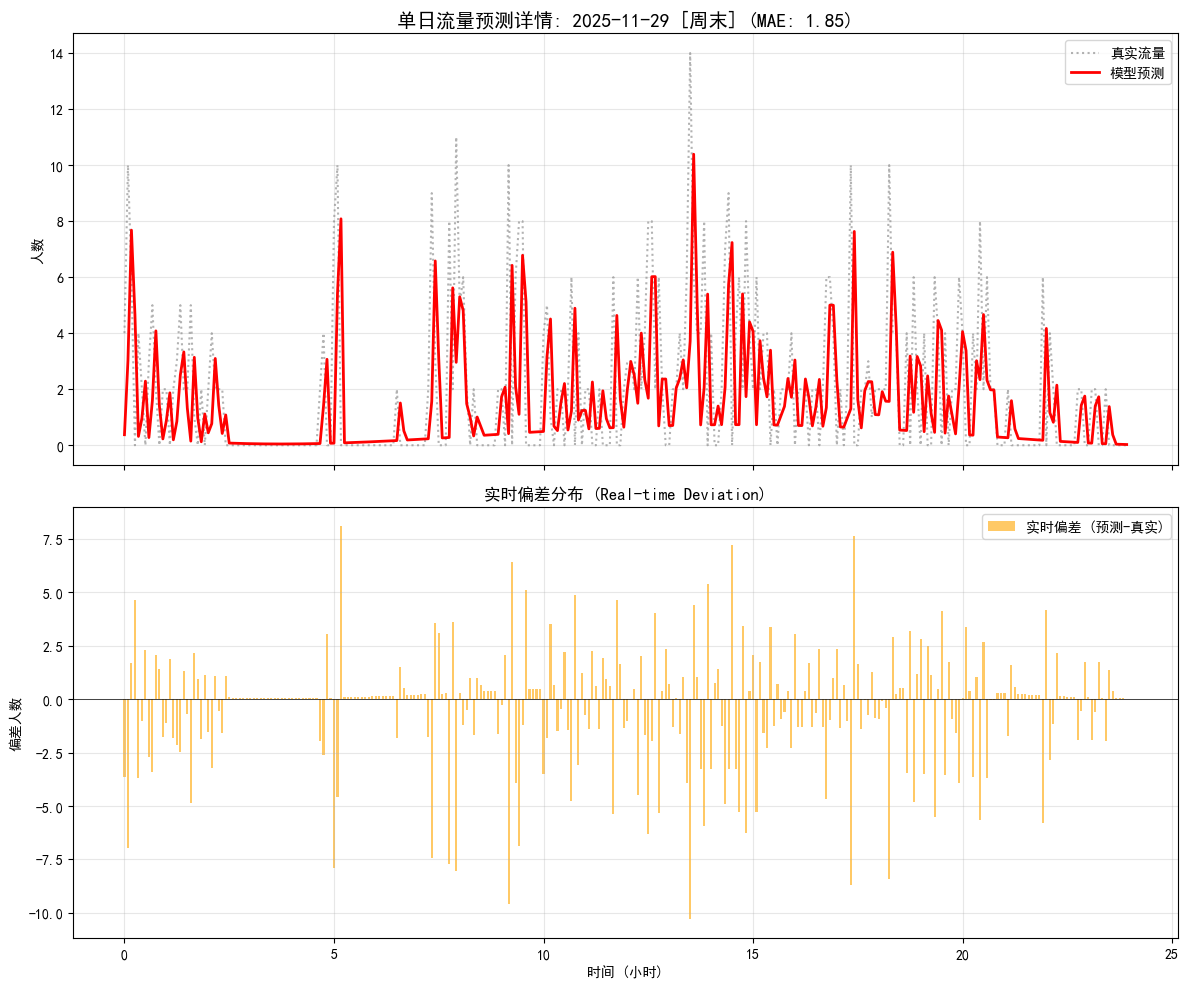


📊 [图2] 全月趋势分析正在进行...
✅ 月度平均误差 (Overall MAE): 7.24


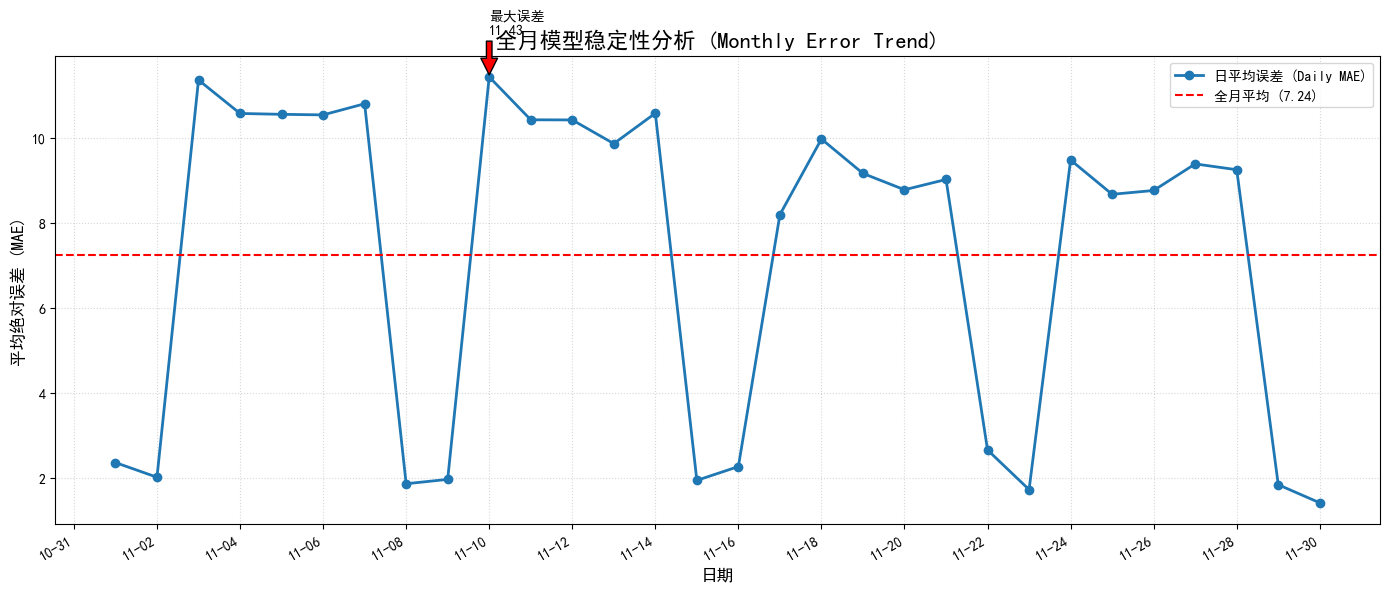

In [37]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import os

# 忽略警告
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 🔮 模块一：Task 1 分时预测器 (工作日/周末分离版)
# ==========================================
class DemandPredictor:
    def __init__(self, raw_data):
        self.raw_data = raw_data
        self.weekday_model = None
        self.weekend_model = None
        self._train_history_models()

    def _train_history_models(self):
        """分别训练 工作日 和 周末 的宏观模型"""
        df = self.raw_data.copy()
        df['Time'] = pd.to_datetime(df['Time'])
        df['DayOfWeek'] = df['Time'].dt.dayofweek 
        
        weekday_df = df[df['DayOfWeek'] < 5]  # 工作日
        weekend_df = df[df['DayOfWeek'] >= 5] # 周末
        
        self.weekday_model = self._fit_poly(weekday_df)
        self.weekend_model = self._fit_poly(weekend_df)

    def _fit_poly(self, df):
        if len(df) == 0: return lambda x: 0
        traffic = df.set_index('Time').resample('5min').size().reset_index()
        traffic.columns = ['Time', 'Count']
        traffic['minutes'] = traffic['Time'].dt.hour * 60 + traffic['Time'].dt.minute
        x = traffic['minutes'].values
        y = traffic['Count'].values
        
        if len(x) > 10:
            coeffs = np.polyfit(x, y, deg=6)
            return np.poly1d(coeffs)
        else:
            return lambda x: 0

    def get_realtime_trend_data(self, current_seconds, day_specific_lookup, is_weekend, window=15):
        current_minutes = (current_seconds // 60) % 1440
        x_local = []
        y_local = []
        
        for m in range(current_minutes - window, current_minutes, 5):
            val = day_specific_lookup.get(m, 0)
            x_local.append(m)
            y_local.append(val)
            
        if len(x_local) < 2: return 0, 0 

        coeffs = np.polyfit(x_local, y_local, deg=1)
        slope = coeffs[0]
        func = np.poly1d(coeffs)
        pred_realtime = max(0, func(current_minutes))
        
        if is_weekend:
            pred_history = max(0, self.weekend_model(current_minutes))
            # 周末模型可以稍微多信任一点实时数据
            final_pred = 0.5 * pred_history + 0.5 * pred_realtime
        else:
            pred_history = max(0, self.weekday_model(current_minutes))
            final_pred = 0.6 * pred_history + 0.4 * pred_realtime
        
        return final_pred, slope

# ==========================================
# 🎮 仿真总控中心 (双图版)
# ==========================================
class SimulationController:
    def __init__(self, data_path):
        try:
            self.full_df = pd.read_csv(data_path)
        except:
            self.full_df = pd.read_csv(data_path, encoding='gbk')
        self.full_df['Time'] = pd.to_datetime(self.full_df['Time'])
        
        self.predictor = DemandPredictor(self.full_df)
        
    def run_random_day_simulation(self):
        """
        📊 功能1: 随机抽取一天，画详细对比图 (图1)
        """
        unique_dates = self.full_df['Time'].dt.date.unique()
        selected_date = random.choice(unique_dates)
        
        pd_date = pd.to_datetime(selected_date)
        is_weekend = pd_date.dayofweek >= 5
        day_type = "周末" if is_weekend else "工作日"
        
        print(f"\n🎲 [图1] 单日详情分析: {selected_date} ({day_type})")
        
        day_df = self.full_df[self.full_df['Time'].dt.date == selected_date].copy()
        day_lookup = day_df.set_index('Time').resample('5min').size()
        day_lookup_dict = { (t.hour * 60 + t.minute): count for t, count in day_lookup.items() }
        
        time_axis = []
        actual_curve = []
        pred_curve = []
        errors = []
        
        for t_min in range(0, 1440, 5): 
            t_seconds = t_min * 60
            pred_val, _ = self.predictor.get_realtime_trend_data(t_seconds, day_lookup_dict, is_weekend)
            actual_val = day_lookup_dict.get(t_min, 0)
            
            time_axis.append(t_min / 60.0)
            actual_curve.append(actual_val)
            pred_curve.append(pred_val)
            errors.append(pred_val - actual_val)

        mae = np.mean(np.abs(errors))
        # 调用画图函数 1
        self._plot_day_detail(selected_date, time_axis, actual_curve, pred_curve, errors, mae, day_type)

    def run_full_month_evaluation(self):
        """
        📊 功能2: 跑全月数据，画误差趋势图 (图2)
        """
        print("\n📊 [图2] 全月趋势分析正在进行...")
        
        unique_dates = sorted(self.full_df['Time'].dt.date.unique())
        date_list = []
        mae_list = []
        
        for date in unique_dates:
            pd_date = pd.to_datetime(date)
            is_weekend = pd_date.dayofweek >= 5
            
            day_df = self.full_df[self.full_df['Time'].dt.date == date]
            day_lookup = day_df.set_index('Time').resample('5min').size()
            day_lookup_dict = { (t.hour * 60 + t.minute): count for t, count in day_lookup.items() }
            
            daily_errors = []
            for t_min in range(0, 1440, 5):
                t_seconds = t_min * 60
                pred_val, _ = self.predictor.get_realtime_trend_data(t_seconds, day_lookup_dict, is_weekend)
                actual_val = day_lookup_dict.get(t_min, 0)
                daily_errors.append(abs(pred_val - actual_val))
            
            daily_mae = np.mean(daily_errors)
            date_list.append(date)
            mae_list.append(daily_mae)
            
        avg_mae = np.mean(mae_list)
        print(f"✅ 月度平均误差 (Overall MAE): {avg_mae:.2f}")
        
        # 调用画图函数 2
        self._plot_monthly_trend(date_list, mae_list, avg_mae)

    # --- 🎨 绘图函数区 ---
    
    def _plot_day_detail(self, date, x, y_actual, y_pred, errors, mae, day_type):
        """画图1: 单日详细对比 (双子图)"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        # 上图：流量对比
        ax1.plot(x, y_actual, label='真实流量', color='gray', linestyle=':', alpha=0.6)
        ax1.plot(x, y_pred, label='模型预测', color='red', linewidth=2)
        ax1.set_title(f'单日流量预测详情: {date} [{day_type}] (MAE: {mae:.2f})', fontsize=14)
        ax1.set_ylabel('人数')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 下图：实时偏差
        ax2.bar(x, errors, color='orange', alpha=0.6, width=0.05, label='实时偏差 (预测-真实)')
        ax2.axhline(0, color='black', linewidth=0.5)
        ax2.set_title('实时偏差分布 (Real-time Deviation)', fontsize=12)
        ax2.set_xlabel('时间 (小时)')
        ax2.set_ylabel('偏差人数')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def _plot_monthly_trend(self, dates, maes, avg_line):
        """画图2: 全月误差趋势 (折线图)"""
        plt.figure(figsize=(14, 6))
        
        plt.plot(dates, maes, marker='o', linestyle='-', color='#1f77b4', linewidth=2, label='日平均误差 (Daily MAE)')
        plt.axhline(y=avg_line, color='red', linestyle='--', label=f'全月平均 ({avg_line:.2f})')
        
        # 标注最大误差
        max_idx = np.argmax(maes)
        plt.annotate(f'最大误差\n{maes[max_idx]:.2f}', 
                     xy=(dates[max_idx], maes[max_idx]), 
                     xytext=(dates[max_idx], maes[max_idx]+1),
                     arrowprops=dict(facecolor='red', shrink=0.05))
        
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
        plt.gcf().autofmt_xdate()
        
        plt.title('全月模型稳定性分析 (Monthly Error Trend)', fontsize=16)
        plt.xlabel('日期', fontsize=12)
        plt.ylabel('平均绝对误差 (MAE)', fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

# ==========================================
# ▶️ 执行区域
# ==========================================
if __name__ == "__main__":
    possible_paths = [r'mcm26Train-B-Data/hall_calls.csv', r'MCM2026/mcm26Train-B-Data/hall_calls.csv', r'hall_calls.csv']
    data_path = None
    for p in possible_paths:
        if os.path.exists(p):
            data_path = p
            break
            
    if data_path:
        sim = SimulationController(data_path)
        
        # 1. 先输出：单日详细图 (验证微观)
        sim.run_random_day_simulation()
        
        # 2. 再输出：全月趋势图 (验证宏观)
        sim.run_full_month_evaluation()
    else:
        print("❌ 找不到文件")